ver: 20201211.1100

In [36]:
# Initialization for this notebook.

import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt

# Common sequence generators.
seq_delta = lambda n_min, n_max: (np.array([ 1 if n==0 else 0 for n in range(n_min, n_max+1)]), 0 - n_min)
seq_u = lambda n_min, n_max: (np.array([ 0 if n<0 else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_R_N = lambda N, n_min, n_max: (np.array([ 0 if (n<0 or n>=N) else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_real_exp = lambda a, n_min, n_max: (np.array([ 0 if n<0 else a**n for n in range(n_min, n_max+1)]), 0-n_min)
seq_complex_exp = lambda sigma, omega_0, n_min, n_max: (np.array([ np.exp((sigma + 1j*omega_0)*n) for n in range(n_min, n_max+1)]), 0-n_min)
seq_sin = lambda A, omega_0, phi, n_min, n_max: (np.array([ A*np.sin(omega_0*n + phi) for n in range(n_min, n_max+1)]), 0-n_min)

# Un-comment the following line to use interactive matplotlib widget.
# %matplotlib widget

In [37]:
# A selection of tick format functions that can be used by `analyze_filter`.
def tick_format_rad_to_pi(value, tick_number):
    """Convert value (in rad) to multiple of pi."""
    return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_pi(value, tick_number):
    """Append pi symbol to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_hz(value, tick_number):
    """Append Hz unit to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + 'Hz'

def analyze_filter(bands, b, a=1, show_plot=False, samples_per_band=129, fs=2, tick_format=tick_format_append_pi, amp_in_dB=True):
    """Find the R_p and A_s of the given filter and optionally show the frequency response plots.
    
    Parameters:
      bands : array_like
        A list of tuples, `(band_type, band_start, band_end)`, to describe each band.
        `band_type`: str, one of 'pass', 'tran', 'stop'
        `band_start`, `band_end`: float, the start and end frequencies, normalized to `fs`.
      b : array_like
        Numerator of the transfer function.
      a : array_like, optional
        Denominator of the transfer function. Default is 1 (FIR filter).
      show_plot : bool, optional
        Set to True to show the frequency response plots. Default is False.
      samples_per_band : int, optional
        Number of frequency samples per band (pass, transition and stop). Generally, more samples will give more accurate results. Default is 129.
      fs: float, optional
        Sampling frequency. Default is 2. (Tips: set to 2*numpy.pi for representing frequencies in rad/sample.)
      tick_format: function, optional
        Function to format tick values on x-axis. Default is `tick_format_append_pi`, which append a pi symbol to the values.
      amp_in_dB: bool, optional
        Whether the amplitude is represented in dB or not. Default is True.
    
    Returns:
      R_p: float
        Pass band ripple, in dB if amp_in_dB is True.
      A_s: float
        Stop band attenuation, in dB if amp_in_dB is True.
    """

    if amp_in_dB:
      dB = lambda x: 20 * np.log10(x)
      amp_unit = '(dB)'
    else:
      dB = lambda x: x
      amp_unit = ''

    NUM_BANDS = len(bands)
    [BAND_TYPE, BAND_START, BAND_END] = range(3)

    # Compute frequency respone samples for each band.
    w = []      # To store frequency samples for each band.
    H = []      # To store frequency respone samples for each band.
    for (band_type, w_start, w_end) in bands:
        w_tmp, H_tmp = signal.freqz(
          b=b, a=a, 
          worN=np.linspace(w_start, w_end, samples_per_band), 
          fs=fs)
        w.append(w_tmp)
        H.append(H_tmp)

    # Normalize |H| to 1.     
    H_abs = np.abs(H)
    H_norm_factor = np.max(H_abs)
    H = H / H_norm_factor
    H_abs = H_abs / H_norm_factor

    # Find the minimum pass band ripple and maximum stop band attenuation (across all respective bands).
    pass_min = 1
    stop_max = 0
    for band in range(NUM_BANDS):
      band_type = bands[band][BAND_TYPE]
      if band_type=='pass':
        pass_min = min(pass_min, np.min(H_abs[band]))
      elif band_type=='stop':
        stop_max = max(stop_max, np.max(H_abs[band]))
    pass_min, stop_max = dB(pass_min), dB(stop_max)
    
    if show_plot:
        NUM_PLOTS = 2
        [AMP_PLOT, PHASE_PLOT] = range(NUM_PLOTS)
        BAND_COLOR = {'pass':'green', 'tran':'blue', 'stop':'red'}

        fig, axs = plt.subplots(NUM_PLOTS, 1 ,sharex='col')

        # Plot the frequency response.
        for band in range(NUM_BANDS):
            band_type = bands[band][BAND_TYPE]
            axs[AMP_PLOT].plot(w[band], dB(H_abs[band]), color=BAND_COLOR[band_type])
            axs[PHASE_PLOT].plot(w[band], np.angle(H[band]), color=BAND_COLOR[band_type])
        axs[AMP_PLOT].legend([bands[band][0] for band in range(3)])
        axs[PHASE_PLOT].set_xlim(left=0, right=fs/2)
        axs[AMP_PLOT].set_ylabel('Amplitude' + amp_unit)
        axs[PHASE_PLOT].set_ylabel('Phase')
        axs[PHASE_PLOT].set_xlabel('Frequency')
        axs[AMP_PLOT].grid()
        axs[PHASE_PLOT].grid()

        # Set the tick format
        axs[PHASE_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        axs[PHASE_PLOT].xaxis.set_major_locator(plt.MultipleLocator(fs/8))
        axs[PHASE_PLOT].yaxis.set_major_formatter(plt.FuncFormatter(tick_format_rad_to_pi))
        axs[PHASE_PLOT].yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))

        # Add horizontal lines to indicate R_p and A_s.
        axs[AMP_PLOT].axhline(y=pass_min, linestyle='--', color=BAND_COLOR['pass'])
        axs[AMP_PLOT].axhline(y=stop_max, linestyle='--', color=BAND_COLOR['stop'])
        axs[AMP_PLOT].secondary_yaxis('right').set_yticks([pass_min, stop_max])

        # Add vertical lines to indicate band egdes.
        band_edges = []
        for band in range(NUM_BANDS):
          band_type, band_start, band_end = bands[band]
          if band_type=='tran':
            for plot in range(NUM_PLOTS):
              axs[plot].axvline(band_start, linestyle='--')
              axs[plot].axvline(band_end, linestyle='--')
              band_edges.append(band_start)
              band_edges.append(band_end)
        ax_phase_top = axs[PHASE_PLOT].secondary_xaxis('top')
        ax_phase_top.xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        ax_phase_top.set_xticks(band_edges)

    if amp_in_dB:
      R_p, A_s = -pass_min, -stop_max
    else:
      R_p, A_s = pass_min, stop_max
    return R_p, A_s

In [38]:
def test_filter(b, a, x):
    """Test a filter by comparing the input and output.

    Parameters:
      b : array_like
        Numerator of the transfer function.
      a : array_like
        Denominator of the transfer function.
      x : array_like
        Input sequence.
    
    Returns:
      y : array_like
        Output sequence.
    """
    y = signal.lfilter(b=b, a=a, x=x)

    X = fft.fft(x)
    Y = fft.fft(y)

    def tick_format_pi(value, tick_number):
        return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

    NUM_PLOTS = 2
    [TIME_PLOT, FREQ_PLOT] = range(NUM_PLOTS)
    fig, axs = plt.subplots(NUM_PLOTS,1)

    N = len(x)
    n = np.arange(N)
    axs[TIME_PLOT].plot(n, x, linewidth=3, color='red', alpha=0.5)
    axs[TIME_PLOT].plot(n, y, linewidth=2, color='green');
    axs[TIME_PLOT].legend(['x', 'y'])
    axs[TIME_PLOT].set_xlabel('n')

    w = n*2*np.pi/N
    axs[FREQ_PLOT].plot(w, abs(X), color='red', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(Y), color='green')
    axs[FREQ_PLOT].legend(['|X|', '|Y|'])
    axs[FREQ_PLOT].set_xlabel('$\omega$')
    axs[FREQ_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
    axs[FREQ_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))

    return y

【参考课本例6.10】设计Butterworth(/Chebyshev I/Chebyshev II/elliptic)型数字低通滤波器。给定性能指标为：在$f$<1kHz的通带内，幅度特性下降小于1dB，在频率大于$f_{st}$=1.5kHz的阻带内，衰减大于15dB，抽样频率为$f_s$=10kHz。

解：

IIR低通滤波器，可以直接使用 `scipy.signal.iirdesign()`函数设计。

type = ellip, order = 3, R_p = 1.000000, A_s = 15.000345
b = [ 0.12143986 -0.05114093 -0.05114093  0.12143986]
a = [ 1.         -2.11117646  1.78430357 -0.53252925]


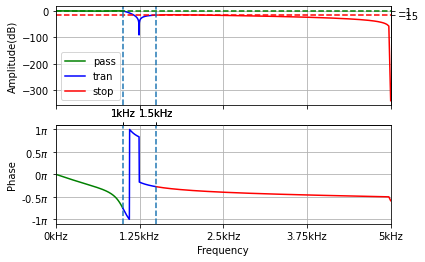

In [39]:
# All frequencies are in Hz.
fs = 10e3
f_p, f_st = 1e3, 1.5e3
R_p_target = 1      # in dB
A_s_traget = 15     # in dB

## Uncomment only one of the following:
# ftype='butter'
# ftype='cheby1'
# ftype='cheby2'
ftype='ellip'

b, a = signal.iirdesign(
    f_p, f_st, 
    R_p_target, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands= [
    ('pass', 0, f_p), 
    ('tran', f_p, f_st), 
    ('stop', f_st, fs/2)
    ]
def tick_format_to_khz(value, tick_number):
    """Show the value in kHz"""
    return ('%.2f' % (value/1000)).rstrip('0').rstrip('.') + 'kHz'
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


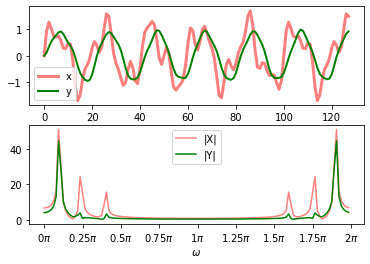

In [40]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 2*np.pi/fs * 0.5e3, 0))    # in the pass band
    x_comp.append((0.5, 2*np.pi/fs * 1.2e3, 0))    # in the tran band
    x_comp.append((0.3, 2*np.pi/fs * 2.0e3, 0))    # in the stop band
    
    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max) for A, w, phi in x_comp], axis=0)[0]

    return x

x = gen_signal()
test_filter(b, a, x);

【参考课本例6.12】设计一个Butterworth(/Chebyshev I/Chebyshev II/elliptic)型数字带通滤波器。技术指标为$f_{st1}$=0.6kHz，$f_{p1}$=1.2kHz，$f_{p2}$=3kHz，$f_{st2}$=4kHz，抽样频率$f_s$=10kHz，$R_p$=2dB，$A_s$=15dB。

解：

各种分段型IIR滤波器，可以使用 `scipy.signal.iirfilter()` 函数设计，但需要计算出所需要的阶数$N$和截止频率$f_c$。

f_c = [1117.80686713 3116.00560988]
type = butter, order = 2, R_p = 2.000000, A_s = 15.181562
b = [ 0.20628091  0.         -0.41256182  0.          0.20628091]
a = [ 1.         -0.69832014  0.50680216 -0.22469269  0.19599286]


C:\Users\14491\AppData\Local\Temp/ipykernel_17152/3649400875.py:45: RuntimeWarning: divide by zero encountered in log10
  dB = lambda x: 20 * np.log10(x)
C:\Users\14491\AppData\Local\Temp/ipykernel_17152/3649400875.py:45: RuntimeWarning: divide by zero encountered in log10
  dB = lambda x: 20 * np.log10(x)


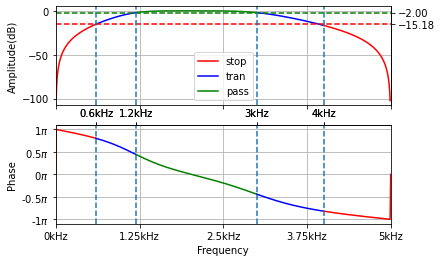

In [41]:
# All frequencies are in Hz.
fs = 10e3
f_st_1, f_p_1  = 0.6e3, 1.2e3
f_p_2 , f_st_2 = 3.0e3, 4.0e3
R_p_target = 2      # in dB
A_s_traget = 15     # in dB

## Uncomment only one of the following:
ftype, forder_function = 'butter', signal.buttord
# ftype, forder_function = 'cheby1', signal.cheb1ord
# ftype, forder_function = 'cheby2', signal.cheb2ord
# ftype, forder_function = 'ellip' , signal.ellipord

# Compute the order and cutoff frequencies.
forder, f_c = forder_function([f_p_1, f_p_2], [f_st_1, f_st_2], R_p_target, A_s_traget, fs=fs)
print('f_c =', f_c)

b, a = signal.iirfilter(
    forder,
    f_c,
    btype='bandpass',
    ftype=ftype,
    rp=R_p_target,
    rs=A_s_traget,
    fs=fs)

# Analyze the filter.
bands= [
    ('stop', 0,      f_st_1), 
    ('tran', f_st_1, f_p_1 ), 
    ('pass', f_p_1,  f_p_2 ), 
    ('tran', f_p_2,  f_st_2), 
    ('stop', f_st_2, fs/2)
    ]
def tick_format_to_khz(value, tick_number):
    """Show the value in kHz"""
    return ('%.2f' % (value/1000)).rstrip('0').rstrip('.') + 'kHz'
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)

【思考】这里计算出来的$N=2$，但系统却是4阶的（$z^{-4}$的系数$a_4$、$b_4$都不为零），为什么？

答：带通滤波器，可以理解为是由一个高通串联上一个低通组成。从系统函数上看，即由一个2阶的高通系统函数乘上一个2阶的低通系统函数。因此总的系统是 $2 \times 2 = 4$ 阶。

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


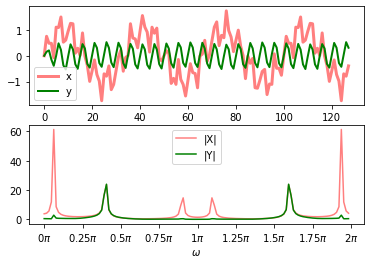

In [42]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 2*np.pi/fs * 0.3e3, 0))    # in the stop band
    x_comp.append((0.5, 2*np.pi/fs * 2.0e3, 0))    # in the pass band
    x_comp.append((0.3, 2*np.pi/fs * 4.5e3, 0))    # in the stop band
    
    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max) for A, w, phi in x_comp], axis=0)[0]

    return x

x = gen_signal()
test_filter(b, a, x);

# 【作业】

设计并分析数字低通滤波器。技术指标要求是：通带截止频率 $\omega_p=0.3\pi$，阻带截止频率为 $\omega_{st}=0.5\pi$，通带纹波 $R_p \leqslant 1 \text{dB}$、阻带衰减为 $A_s \geqslant 40\text{dB}$）。

- 分别设计阶数最少的FIR和IIR低通滤波器，并使用`analyze_filter()`和`test_filter()`函数对它们进行分析和测试。
- 输入以下序列，将输入、FIR滤波器的输出、IIR滤波器的输出画在同一个坐标系中，分析对比三个序列的异同并说明原因。
    - 输入一个频率在通带范围内的正弦序列
    - 输入序列 $x(n)=\sin(0.1\pi n) + 0.3 \sin(0.2\pi n)$

In [43]:
# All frequencies are in Hz.
# 采样频率 2Hz
fs = 2
w_p, w_st = 0.3, 0.5
R_p_target = 1      # in dB
A_s_traget = 40     # in dB

题目要求选用阶数最小的滤波器，这里我们选择ellip，因为其阶次最低

type = ellip, order = 4, R_p = 0.999808, A_s = 39.999808
b = [0.03530677 0.02337488 0.05604963 0.02337488 0.03530677]
a = [ 1.         -2.32099329  2.67715549 -1.57739126  0.41580156]


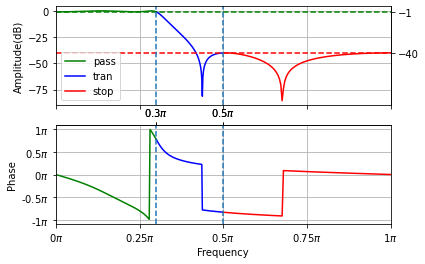

In [44]:
# Uncomment only one of the following:
# ftype='butter'
# ftype='cheby1'
# ftype = 'cheby2'
ftype = 'ellip'

b, a = signal.iirdesign(
    w_p, w_st,
    R_p_target, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands = [
    ('pass', 0, w_p),
    ('tran', w_p, w_st),
    ('stop', w_st, fs/2)
]


R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True,
                          fs=fs, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)


观察到，A_s=39.999808, 与要求中的40dB不相符
我们选择阶数次低的滤波器cheby1

type = cheby1, order = 5, R_p = 1.000000, A_s = 44.356669
b = [0.00202017 0.01010085 0.02020169 0.02020169 0.01010085 0.00202017]
a = [ 1.         -3.16236465  4.76070036 -4.05279408  1.93439053 -0.41528674]


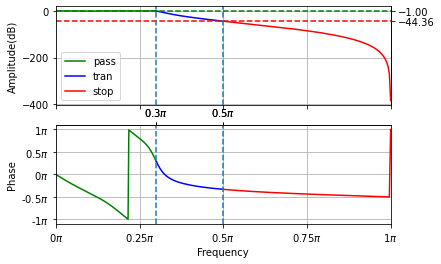

In [53]:
# Uncomment only one of the following:
# ftype='butter'
ftype='cheby1'
# ftype = 'cheby2'
# ftype = 'ellip'

b, a = signal.iirdesign(
    w_p, w_st,
    R_p_target, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands = [
    ('pass', 0, w_p),
    ('tran', w_p, w_st),
    ('stop', w_st, fs/2)
]


R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True,
                          fs=fs, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)


观察到，此时通带最大衰减与阻带最小衰减均符合要求

## 测试IIR滤波器

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([ 0.        ,  0.00194114,  0.01704906,  0.07172634,  0.19367492,
        0.37931023,  0.57952609,  0.73352682,  0.81979055,  0.86053331,
        0.87083458,  0.81830379,  0.65125471,  0.36609058,  0.02956995,
       -0.27417415, -0.50883443, -0.68837384, -0.82419777, -0.89235198,
       -0.86056328, -0.73143404, -0.54038996, -0.31443703, -0.05379055,
        0.23721019,  0.51696606,  0.72475203,  0.83229517,  0.86041654,
        0.8373754 ,  0.75472177,  0.58116815,  0.31696202,  0.0148584 ,
       -0.26176014, -0.48947749, -0.67995456, -0.8313587 , -0.90675244,
       -0.87017868, -0.73055442, -0.53284589, -0.3088545 , -0.05586708,
        0.22894658,  0.50911622,  0.72318694,  0.83756099,  0.86782882,
        0.84115664,  0.75250061,  0.57534706,  0.312301  ,  0.01459299,
       -0.25813457, -0.48530086, -0.67848364, -0.83331937, -0.91015185,
       -0.87220697, -0.72984202, -0.53031055, -0.306687  , -0.0556837 ,
        0.22726254,  0.50709356,  0.7224111 ,  0.8384571 ,  0.86

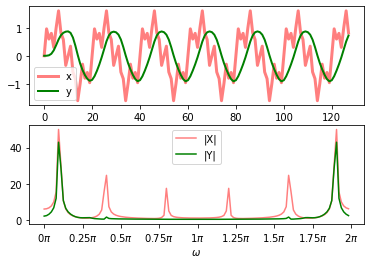

In [51]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 0.1 * np.pi, 0))    # in the pass band
    x_comp.append((0.5, 0.4 * np.pi, 0))    # in the tran band
    x_comp.append((0.3, 0.8 * np.pi, 0))    # in the stop band

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()
test_filter(b, a, x)


观察到，通带信号得到保留，阻带、过渡带信号被滤除

## FIR滤波器

根据上一次作业，选择凯泽窗

type = cheby1, order = 23, R_p = 0.122891, A_s = 41.851606
b = [ 3.88654077e-03  4.05153612e-03 -6.24365476e-03 -1.47358211e-02
  8.01632110e-18  2.86077710e-02  2.41554552e-02 -3.31602458e-02
 -7.54951559e-02  1.45406984e-17  1.96560231e-01  3.72373343e-01
  3.72373343e-01  1.96560231e-01  1.45406984e-17 -7.54951559e-02
 -3.31602458e-02  2.41554552e-02  2.86077710e-02  8.01632110e-18
 -1.47358211e-02 -6.24365476e-03  4.05153612e-03  3.88654077e-03]
a = 1


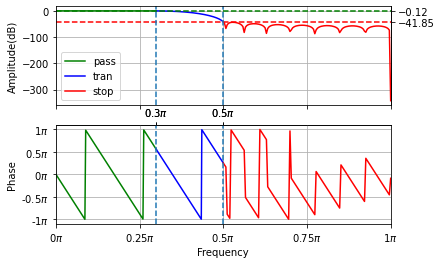

In [55]:
# 过渡带宽度
f_tran = abs(w_p - w_st)

# Compute window property.
# 过渡带宽度，表示为 过渡带带宽 / 奈奎斯特频率
width = f_tran / (fs / 2)
# 使用kaiserord计算凯泽窗参数，第一个参数为阻带最小衰减(单位dB), 第二个参数为过渡带宽度
N, beta = signal.kaiserord(A_s_traget, width)
window = ('kaiser', beta)

# Compute the FIR coefficients.
w_c = (w_p + w_st) / 2
FIR_b = signal.firwin(N, w_c, window=window, fs=fs)
FIR_a = 1
# 计算FIR滤波器阶数
forder = N - 1

R_p, A_s = analyze_filter(bands, b=FIR_b, a=FIR_a, show_plot=True,
                          fs=fs, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', FIR_b)
print('a =', FIR_a)


观察到，FIR滤波器通带最大衰减和阻带最小衰减均符合要求

## 测试FIR滤波器

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([ 0.00000000e+00,  3.73450251e-03,  6.21082443e-03, -4.72282497e-04,
       -1.34769982e-02, -8.68681644e-03,  2.41067941e-02,  3.92904628e-02,
       -1.37391073e-02, -9.21339760e-02, -5.27836257e-02,  1.83469623e-01,
        4.85578242e-01,  6.37216165e-01,  6.12892888e-01,  6.37301889e-01,
        8.77939272e-01,  1.15502420e+00,  1.11704354e+00,  6.91549866e-01,
        2.14838148e-01,  1.60508475e-02, -6.10552051e-03, -2.15310431e-01,
       -7.05026864e-01, -1.12573036e+00, -1.13091741e+00, -8.38648810e-01,
       -6.51040996e-01, -7.05026864e-01, -6.89999791e-01, -3.02108620e-01,
        3.02108620e-01,  6.89999791e-01,  7.05026864e-01,  6.51040996e-01,
        8.38648810e-01,  1.13091741e+00,  1.12573036e+00,  7.05026864e-01,
        2.15310431e-01,  9.84002302e-03, -9.84002302e-03, -2.15310431e-01,
       -7.05026864e-01, -1.12573036e+00, -1.13091741e+00, -8.38648810e-01,
       -6.51040996e-01, -7.05026864e-01, -6.89999791e-01, -3.02108620e-01,
        3.02108620e-01,  

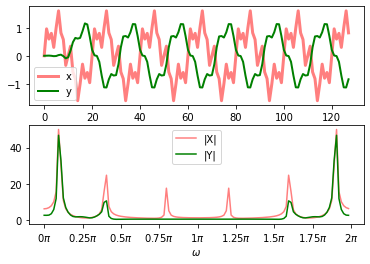

In [56]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 0.1 * np.pi, 0))    # in the pass band
    x_comp.append((0.5, 0.4 * np.pi, 0))    # in the tran band
    x_comp.append((0.3, 0.8 * np.pi, 0))    # in the stop band

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()
test_filter(FIR_b, FIR_a, x)

In [58]:
def test_filter_IIR_FIR(IIR_b, IIR_a, FIR_b, FIR_a, x):
    """Test a filter by comparing the input and output.

    Parameters:
      IIR_b : array_like
        Numerator of the IIR transfer function.
      IIR_a : array_like
        Denominator of the IIR transfer function.
      FIR_b : array_like
        Numerator of the FIR transfer function.
      FIR_a : array_like
        Denominator of the FIR transfer function.
      x : array_like
        Input sequence.
    
    Returns:
      IIR_y : array_like
        Output sequence of IIR.
      FIR_y : array_like
        Output sequence of IIR.
    """
    IIR_y = signal.lfilter(b=IIR_b, a=IIR_a, x=x)  # IIR滤波器输出
    FIR_y = signal.lfilter(b=FIR_b, a=FIR_a, x=x)  # FIR滤波器输出

    X = fft.fft(x)
    IIR_Y = fft.fft(IIR_y)
    FIR_Y = fft.fft(FIR_y)

    def tick_format_pi(value, tick_number):
        return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

    NUM_PLOTS = 2
    [TIME_PLOT, FREQ_PLOT] = range(NUM_PLOTS)
    fig, axs = plt.subplots(NUM_PLOTS, 1)

    N = len(x)
    n = np.arange(N)
    axs[TIME_PLOT].plot(n, x, linewidth=3, color='red', alpha=0.5)
    axs[TIME_PLOT].plot(n, IIR_y, linewidth=2, color='green')
    axs[TIME_PLOT].plot(n, FIR_y, linewidth=1, color='blue')
    axs[TIME_PLOT].legend(['x', 'IIR_y', 'FIR_y'])
    axs[TIME_PLOT].set_xlabel('n')

    w = n*2*np.pi/N
    axs[FREQ_PLOT].plot(w, abs(X), color='red', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(IIR_Y), color='green')
    axs[FREQ_PLOT].plot(w, abs(FIR_Y), color='blue')
    axs[FREQ_PLOT].legend(['|X|', '|IIR_Y|', '|FIR_Y|'])
    axs[FREQ_PLOT].set_xlabel('$\omega$')
    axs[FREQ_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
    axs[FREQ_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))

    return IIR_y, FIR_y

输入一个频率在通带范围内的正弦序列

(array([ 0.00000000e+00,  6.24266675e-04,  6.28291802e-03,  3.07110783e-02,
         9.79485391e-02,  2.30764304e-01,  4.30168544e-01,  6.61932001e-01,
         8.63904854e-01,  9.72535233e-01,  9.52078131e-01,  8.07891877e-01,
         5.77042648e-01,  3.05264635e-01,  2.70547214e-02, -2.39440256e-01,
        -4.83681167e-01, -6.90903213e-01, -8.38205537e-01, -9.01522126e-01,
        -8.67358597e-01, -7.40077344e-01, -5.39855059e-01, -2.93852261e-01,
        -2.75551234e-02,  2.38243655e-01,  4.84758505e-01,  6.91346301e-01,
         8.35335666e-01,  8.96810250e-01,  8.65335340e-01,  7.44070202e-01,
         5.48753251e-01,  3.02705727e-01,  3.13306141e-02, -2.40954321e-01,
        -4.90977717e-01, -6.96238526e-01, -8.35811174e-01, -8.93417353e-01,
        -8.61264510e-01, -7.42395738e-01, -5.50199130e-01, -3.05512173e-01,
        -3.30015124e-02,  2.41622624e-01,  4.93164110e-01,  6.98027608e-01,
         8.35835329e-01,  8.91850794e-01,  8.59494465e-01,  7.41801221e-01,
         5.5

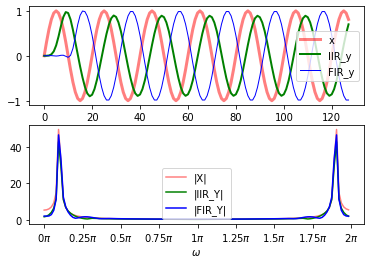

In [59]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 0.1*np.pi, 0))    # in the pass band

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()
test_filter_IIR_FIR(b, a, FIR_b, FIR_a, x)


观察到，两个滤波器输出信号与输入信号相比均有一个延迟，IIR滤波器相位延迟比FIR相位延时更小，IIR输出的信号相比FIR有一定的衰减

原因：FIR滤波器阶数比IIR更高

输入序列 $x(n)=\sin(0.1\pi n) + 0.3 \sin(0.2\pi n)$

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([ 0.00000000e+00,  9.80494409e-04,  9.76696726e-03,  4.70536277e-02,
         1.47051177e-01,  3.36763868e-01,  6.03464391e-01,  8.78824466e-01,
         1.06152281e+00,  1.07038662e+00,  8.93448865e-01,  5.97753114e-01,
         2.91334341e-01,  6.19945239e-02, -6.74751833e-02, -1.40926591e-01,
        -2.30428444e-01, -3.85538424e-01, -6.01767638e-01, -8.23217420e-01,
        -9.71828242e-01, -9.82729944e-01, -8.27721905e-01, -5.21009108e-01,
        -1.12069028e-01,  3.26830588e-01,  7.14912739e-01,  9.79450469e-01,
         1.07423994e+00,  9.94835451e-01,  7.82092728e-01,  5.08453853e-01,
         2.50066118e-01,  5.67396105e-02, -6.55081486e-02, -1.50445735e-01,
        -2.48448933e-01, -3.96209094e-01, -5.94288477e-01, -8.02568430e-01,
        -9.54475190e-01, -9.82687848e-01, -8.45414363e-01, -5.43668387e-01,
        -1.24319162e-01,  3.31386411e-01,  7.30047340e-01,  9.92459872e-01,
         1.07607937e+00,  9.86155895e-01,  7.71228005e-01,  5.03991169e-01,
         2.5

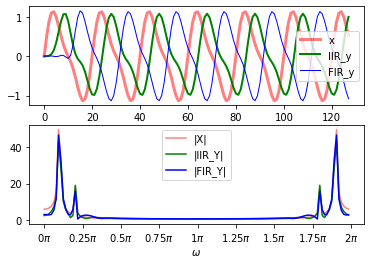

In [60]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 0.1*np.pi, 0))    # in the pass band  sin(0.1πn)
    x_comp.append((0.3, 0.2*np.pi, 0))    # in the pass band  0.3sin(0.2πn)

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()
test_filter_IIR_FIR(b, a, FIR_b, FIR_a, x)


观察到，两个滤波器输出信号与输入信号相比均有一个延迟，IIR滤波器相位延迟比FIR相位延时更小，IIR输出的信号相比FIR有一定的衰减

原因：FIR滤波器阶数比IIR更高